# PC analysis

## Principal components analysis theory

In this notebook, the Principal Component Analysis (PCA) is performed. With this dimensionality reduction technique we are able to reduce the dimension of the data, which in the case of a regional predictor for the sea-level-pressure fields, exceeds the thousands of variables... All the python code is hosted at `sscode/pca.py`, where we use the scikit-learn package available [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

Regarding the maths, an explanation of what PCA is can be found at [wikipedia](https://en.wikipedia.org/wiki/Principal_component_analysis), but it will be briefly explained here:

The PCA reduces the dimension of the data by means of a projection in a lower dimensional space that preserves the maximum variance of the sample data. The new vectors are formed by the ones where the projected data have the higher variance. Given the spatiotemporal variable $X_i (x, t_i)$, where $x$ is the spatial data position of dimension $3n1 + 2n2$ and $t_i$ is the time, we apply PCA to obtain a new $d$-dimensional space. The eigenvectors [empirical orthogonal functions (EOFs)] of the covariance matrix of the data define the vectors of the new space. The idea of PCA is to find the minimum $d$ linearly EOFs, so that the transformed components of the original data [principal components (PCs)] explain the maximum variance necessary in the problem at hand. The original data can be expressed as a linear combination of EOFs and PCs,

$$
\boxed{
X (x,t_i) = EOF_1(x)\times PC_1(t_i) + EOF_2(x)\times PC_2(t_i) + ... + EOF_d(x)\times PC_d(t_i)
}
$$

Once we apply PCA, our data are defined by the principal components $X_i^{EOF}={PC_1,PC_2,...,PC_d}, i=1,...,P $. A better explanation can be also found [here](https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-unsupervised-learning)!!

```{figure} ../media/images/pca-analysis.png
---
width: 600px
name: pca
---
This picture shows how the dimensionality reduction that performs PCA might help when identifying patterns in data ([image reference](https://programmerclick.com/images/486/0351bfe3610a3ba89bea599ee9d054ae.png))
```

In [1]:
# basics
import os, sys

# append sscode to path
sys.path.insert(0, os.path.join(os.path.abspath(''), '..'))

# custom
from sscode.data import Loader, load_moana_hindcast_ss
from sscode.pca import PCA_DynamicPred
from sscode.config import default_region_reduced

# warnings
import warnings
warnings.filterwarnings('ignore')

## Load the data without plotting

As always, we first load the data using our `Loader` python class, so then we can easily use all the datasets. Notice that here, we set the `plot` parameter to `False`.

In [2]:
# load the data
load_cfsr_moana_uhslc = Loader(
    data_to_load=['cfsr','moana','uhslc'], plot=False
)


 loading the sea-level-pressure fields... 


 loading daily resampled data... 


 loading the Moana v2 hindcast data... 


 loading and plotting the UHSLC tidal guages... 



## PCA usage explanation 

To use the pre-build PCA functions, the user must get familiar with the datasets and the way everything is programmed. 

```{tip}
For this reason, have always in mind that [xarray](http://xarray.pydata.org/en/stable/getting-started-guide/why-xarray.html) will be the main python data analysis library used in the project, and then, python functions will usually depend on these [Datasets](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.html) / [DataArrays](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html), which are very useful when working with multiple dimensions and variables
```

regarding the PCA usage, have a look at the piece of code below:

```python
    def PCA_DynamicPred(pres, pres_vars: tuple = ('SLP','longitude','latitude'),
                        calculate_gradient: bool = False,
                        winds: tuple = (False,None),
                        wind_vars: tuple = ('wind_proj_mask','lon','lat'),
                        time_lapse: int = 1, # 1 equals to NO time delay 
                        time_resample: str = '1D',
                        region: tuple = (True,default_region),
                        pca_plot: tuple = (True,False),
                        verbose: bool = True,
                        pca_ttls = None, pca_borders = None):
        """
        Perform PCA decomposition given the pressure, winds...

        Args:
            pres (xarray.Dataarray/Dataset): These are the sea-level-pressure fields,
                that could be loaded  both with load_era5() or load_cfsr(), and
                obviously with the Loader object!!
                    ** this parameter can be used to calculate PCA 
                       with different data 
                    **
            pres_vars (tuple, optional): These are the slp xarray coordinates. 
                - Defaults to ('msl','longitude','latitude').
            calculate_gradient (bool, optional): weather to calculate or not the slp gradient.
                - Defaults to False.
            winds (tuple, optional): This is the wind data, if available...
                - Defaults to (False,None), data must be xarray!!
            wind_vars (tuple, optional): These are the wind coordinates. 
                - Defaults to ('wind_proj','longitude','latitude').
            time_lapse (int, optional): Time delay for the dynamic predictor. 
                - Defaults to 2.
            time_resample (str, optional): This is the time resample.
                - Defaults to '1D'.
            region (tuple, optional): Region to crop the slp to. 
                - Defaults to (True,default_region).
            pca_plot (tuple, bool): Wether to plot or not the final results.
                - Defaults to (True,False), as the second boolean indicator refers
                to the de-standarization of the EOFs, which is not totally validated
            verbose (bool, optional): Wether or not to debug the actions.
                - Defaults to True.
            pca_ttls: These are the titles for the pca plots if wanted.
            pca_borders: Limits to use in the pca plots.

        Returns:
            [xarray.Dataset]: PCA decomposition final results
        """
```

as this is the aspect of all the functions that are used. For this particular case, we must give the function the previouly loaded slp fields, which are stored at `load_cfsr_moana_uhslc.predictor_slp`, and then specify the actions that we want to perform over this raw dataset. Here some examples of the available actions:

## PCA examples:

Below, different PCA analysis with different inputs are shown:

### Regional PCs analysis


 plotting 3 components with 2 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



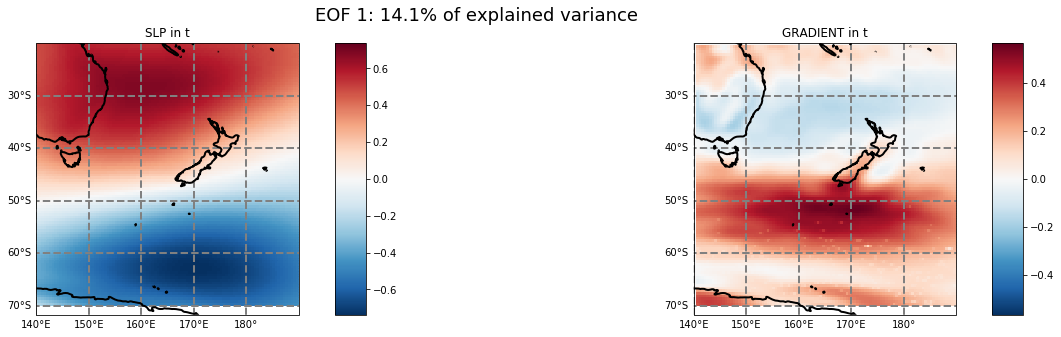

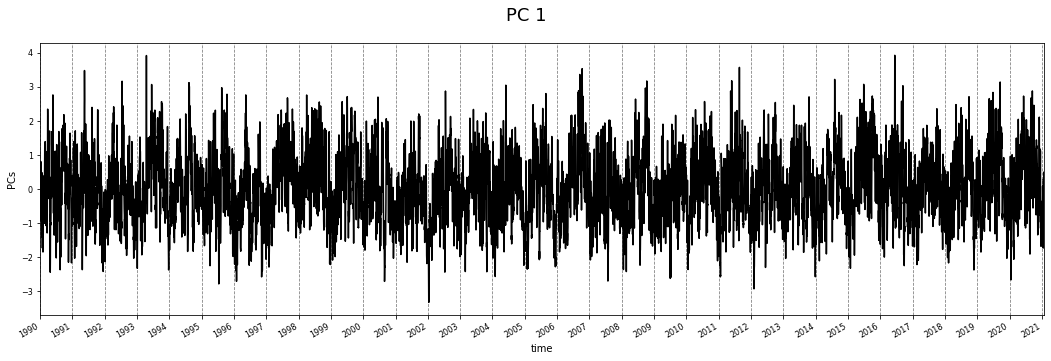

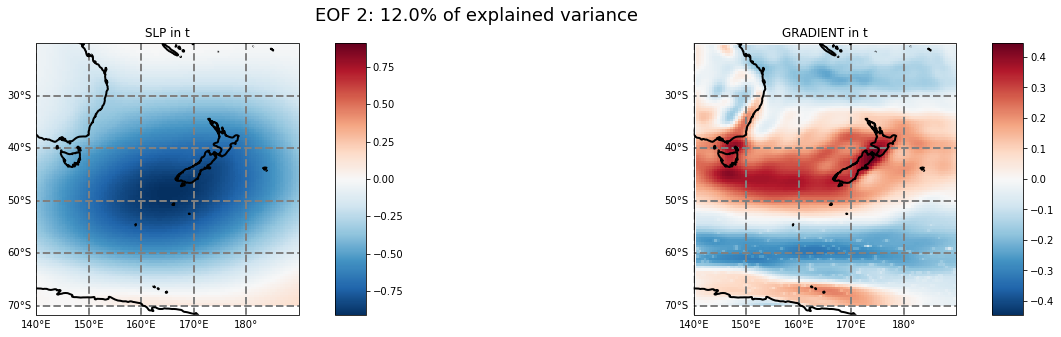

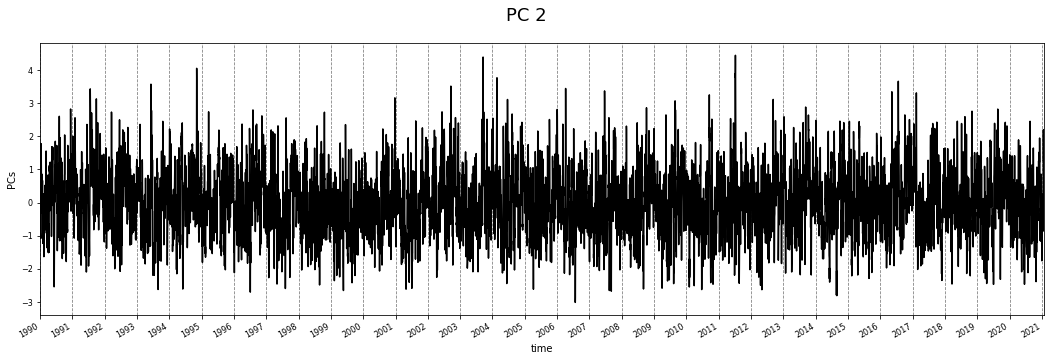

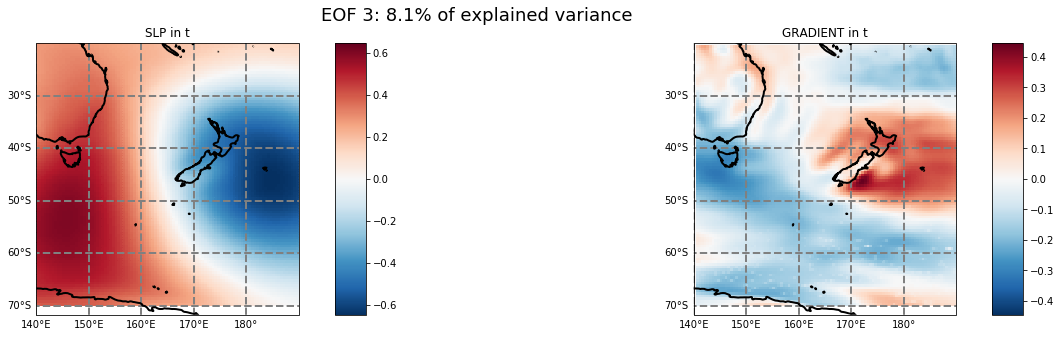

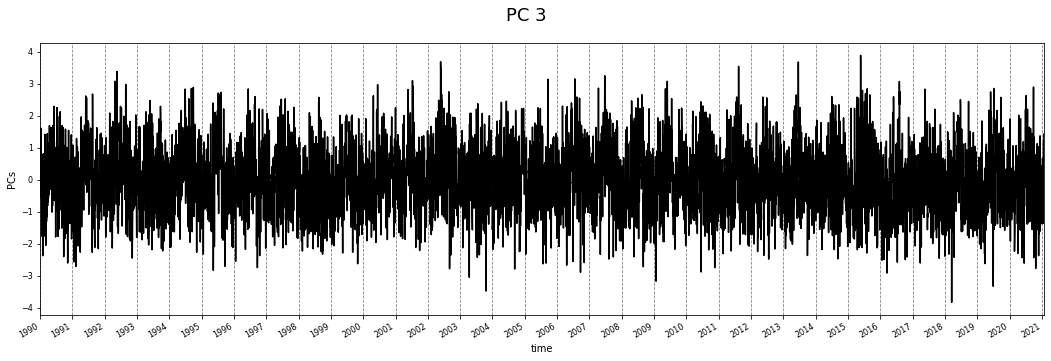

In [3]:
# load / calculate the regional pcs
if os.path.isfile('../data/cfsr/cfsr_regional_daily_pcs.nc'):
    import xarray as xr
    pcs_cfsr = xr.open_dataset(
        '../data/cfsr/cfsr_regional_daily_pcs.nc'
    )
    from sscode.plotting.pca import plot_pcs
    plot_pcs(pcs_cfsr,n_plot=3)
else:
    # here is how this loaded regional pcs were calculated
    pcs_data, pcs_scaler = PCA_DynamicPred(
        load_cfsr_moana_uhslc.predictor_slp, 
        calculate_gradient=True
    ) # look the simplicity of the function

### Local-Regional PCs (with gradient)


 lets calculate the PCs... 


 calculating the gradient of the sea-level-pressure fields... 


 pressure/gradient predictor both with shape: 
 (11354, 25, 25) 


 calculated PCs matrix with shape: 
 (11353, 1250) 


 plotting 3 components with 2 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



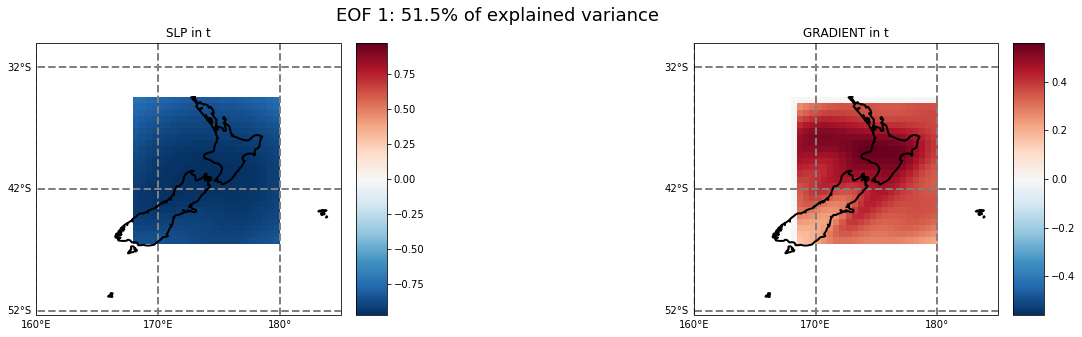

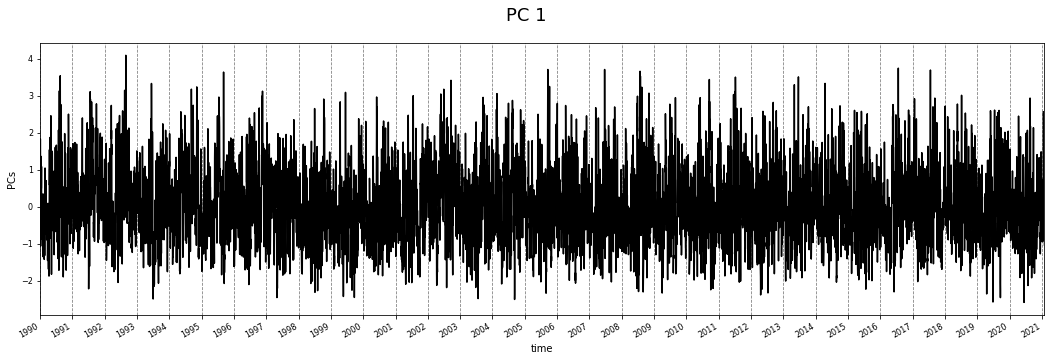

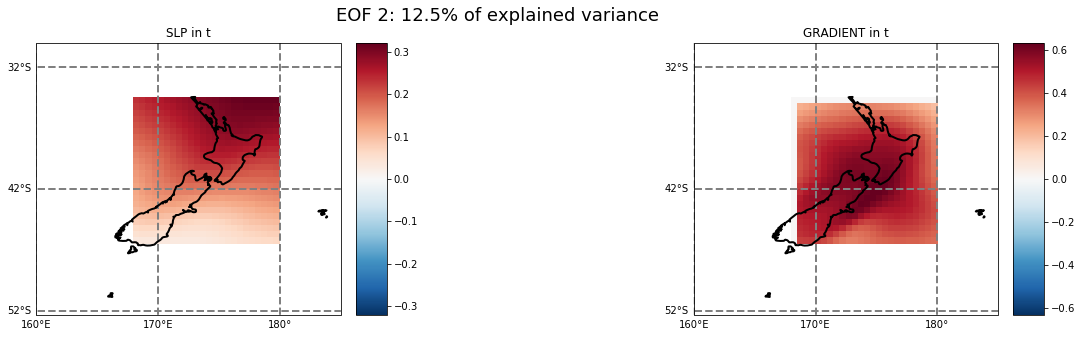

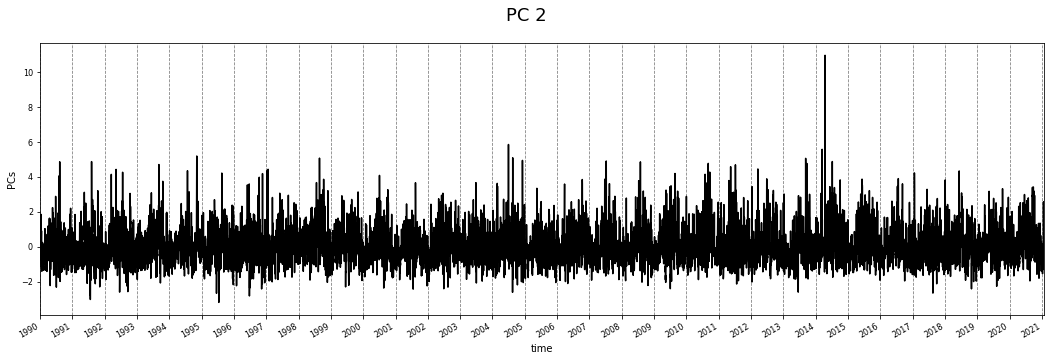

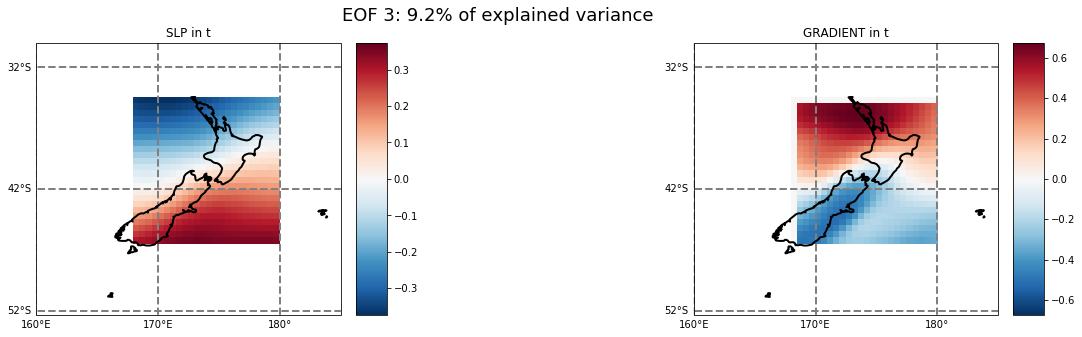

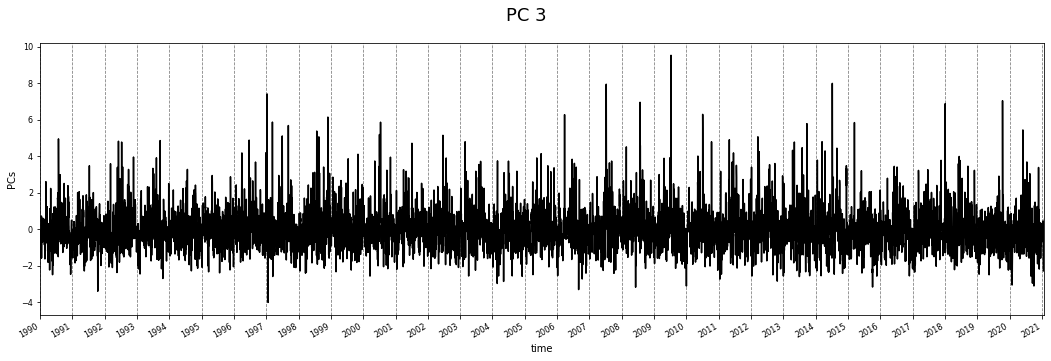


 plotting reconstruction of 2 EOFs... 


 being the EOFs the slp, the gradient, in steps t, t-1... 



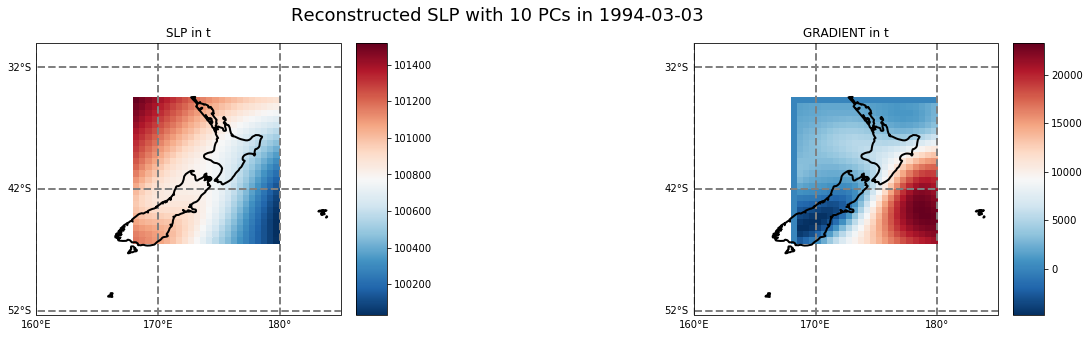

In [4]:
# calculate some local pcs
pcs_data, pcs_scaler = PCA_DynamicPred(
    load_cfsr_moana_uhslc.predictor_slp, 
    calculate_gradient=True, time_lapse=1, # 1 = NO time lapse
    region=(True,(
        load_cfsr_moana_uhslc.location[0]-6.1,
        load_cfsr_moana_uhslc.location[0]+6.1,
        load_cfsr_moana_uhslc.location[1]+6.1,
        load_cfsr_moana_uhslc.location[1]-6.1
    )),
    pca_plot=(True,False,3) # (plot,scale,n_plot)
)
if True:
    from sscode.plotting.pca import plot_recon_pcs
    recon_slp = plot_recon_pcs(
        pcs_data, pcs_scaler,
        region=default_region_reduced,
        return_slp=True
    )

### Local PCs (with wind and gradient)


 lets calculate the PCs... 


 adding the wind to the predictor... 


 winds predictor with shape: 
 (11354, 11, 11) 


 calculating the gradient of the sea-level-pressure fields... 


 pressure/gradient predictor both with shape: 
 (11354, 11, 11) 


 calculated PCs matrix with shape: 
 (11353, 363) 


 plotting 2 components with 3 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



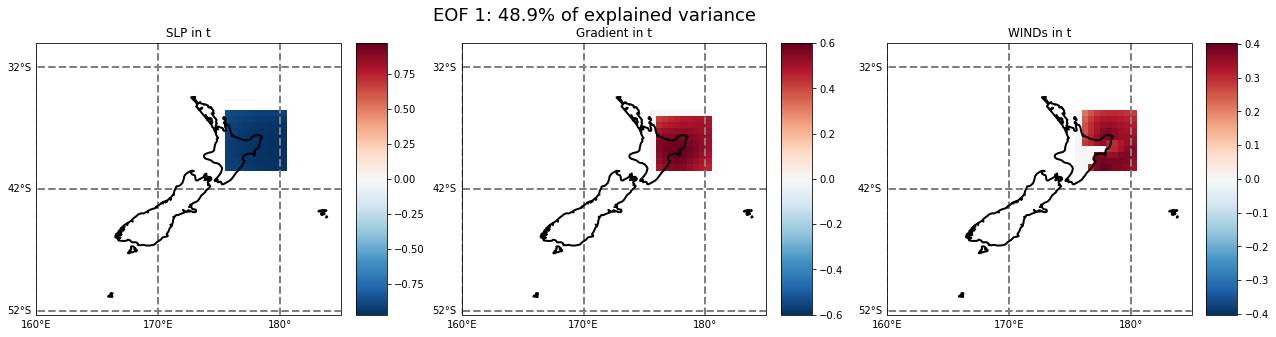

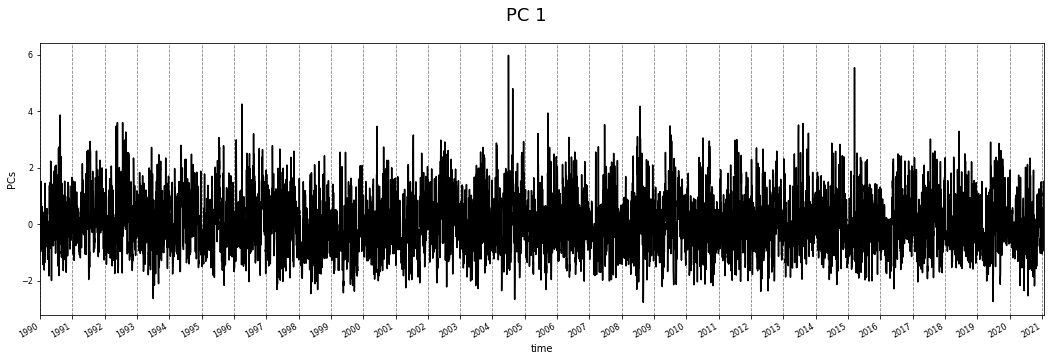

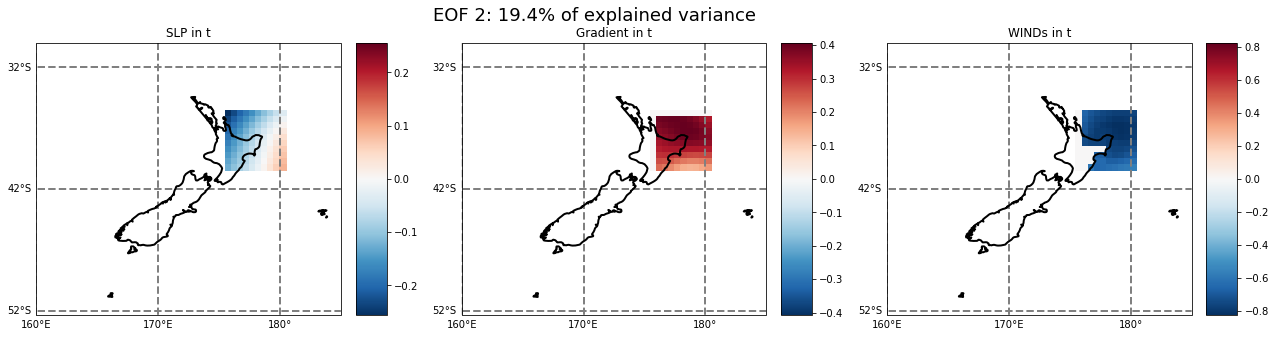

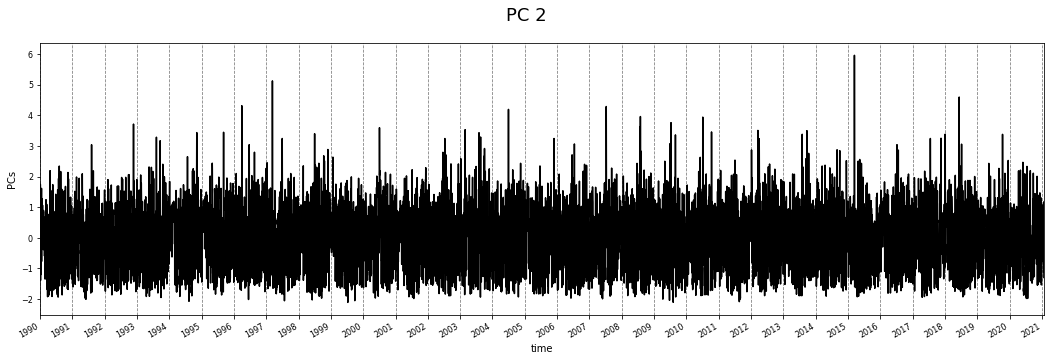

(<xarray.Dataset>
 Dimensions:   (n_components: 363, n_features: 363, n_lat: 11, n_lon: 11, time: 11353)
 Coordinates:
   * time      (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-01-30
 Dimensions without coordinates: n_components, n_features, n_lat, n_lon
 Data variables:
     PCs       (time, n_components) float64 -7.43 4.781 ... 2.259e-18 1.382e-19
     EOFs      (n_components, n_features) float64 -0.07382 -0.07481 ... 0.0 0.0
     variance  (n_components) float64 138.3 54.97 42.0 ... 8.679e-35 5.777e-36
     pcs_lon   (n_lon) float32 175.5 176.0 176.5 177.0 ... 179.5 180.0 180.5
     pcs_lat   (n_lat) float32 -35.5 -36.0 -36.5 -37.0 ... -39.5 -40.0 -40.5,
 StandardScaler())

In [5]:
# more pcs in new location
new_location = (178,-38)
PCA_DynamicPred(
    load_cfsr_moana_uhslc.predictor_slp, 
    calculate_gradient=True, time_lapse=1,
    region=(True,(
        new_location[0]-2.6,new_location[0]+2.6,
        new_location[1]+2.6,new_location[1]-2.6
    )),
    winds=(True,load_cfsr_moana_uhslc.predictor_wind),
    wind_vars=('wind_proj_mask','lon','lat'),
    pca_plot=(True,False,2),
    pca_ttls=['SLP in t','Gradient in t','WINDs in t']
)

### Local PCs (just SLP with time lapse)


 lets calculate the PCs... 


 calculated PCs matrix with shape: 
 (11349, 605) 


 plotting 3 components with 5 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



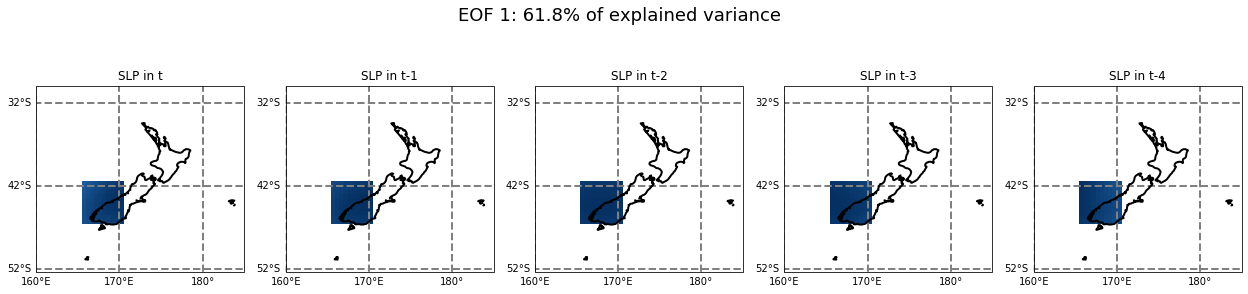

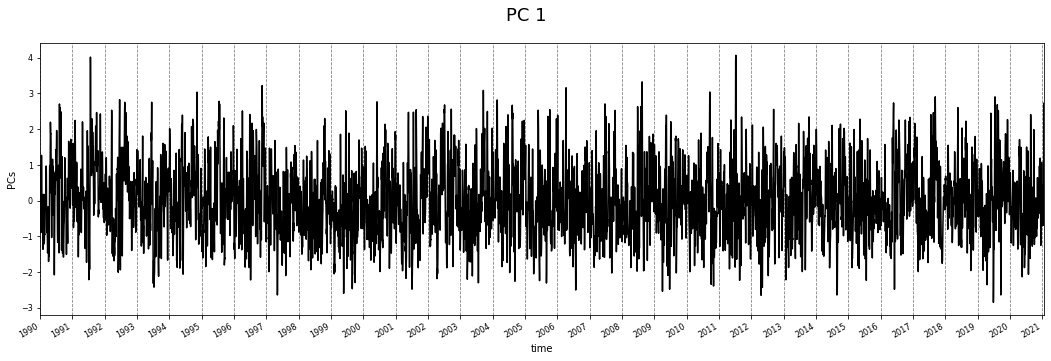

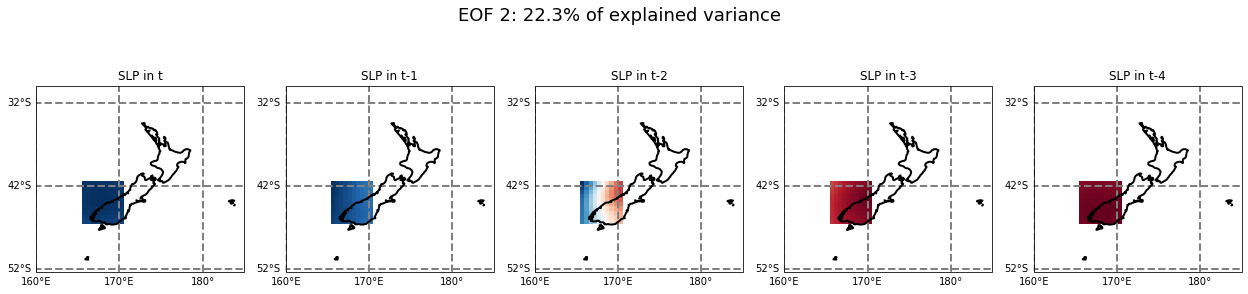

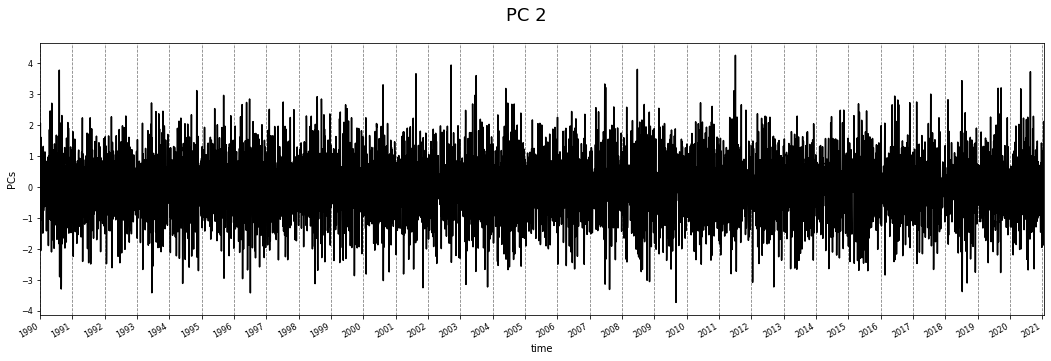

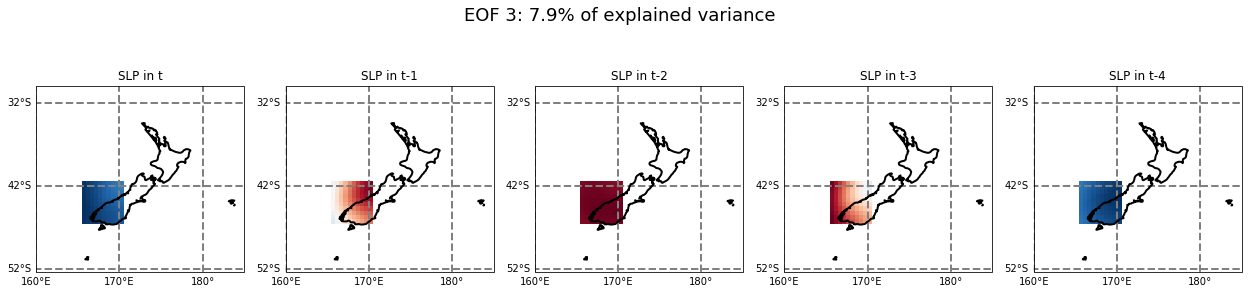

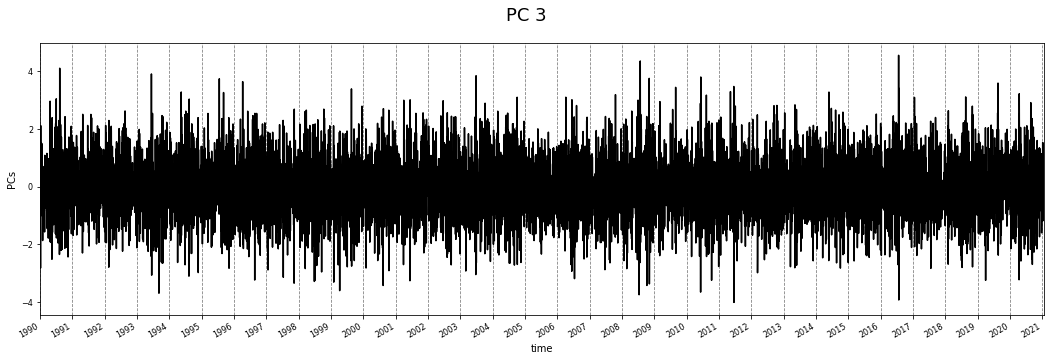

(<xarray.Dataset>
 Dimensions:   (n_components: 605, n_features: 605, n_lat: 11, n_lon: 11, time: 11349)
 Coordinates:
   * time      (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-01-26
 Dimensions without coordinates: n_components, n_features, n_lat, n_lon
 Data variables:
     PCs       (time, n_components) float64 -15.87 -0.9563 ... -6.611e-06
     EOFs      (n_components, n_features) float64 -0.03065 -0.03139 ... -0.009912
     variance  (n_components) float64 374.0 134.9 47.98 ... 2.325e-11 2.303e-11
     pcs_lon   (n_lon) float32 165.5 166.0 166.5 167.0 ... 169.5 170.0 170.5
     pcs_lat   (n_lat) float32 -41.5 -42.0 -42.5 -43.0 ... -45.5 -46.0 -46.5,
 StandardScaler())

In [6]:
# more pcs with time lapse
new_location = (168,-44)
PCA_DynamicPred(
    load_cfsr_moana_uhslc.predictor_slp, 
    calculate_gradient=False, time_lapse=5,
    region=(True,(
        new_location[0]-2.6,new_location[0]+2.6,
        new_location[1]+2.6,new_location[1]-2.6
    )),
    pca_plot=(True,False,3),
    pca_ttls=['SLP in t','SLP in t-1','SLP in t-2','SLP in t-3','SLP in t-4']
)

### Storm-Surge PCs


 loading the Moana v2 hindcast data (ss)... 


 lets calculate the PCs... 


 calculated PCs matrix with shape: 
 (8065, 4032) 


 plotting 3 components with 2 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



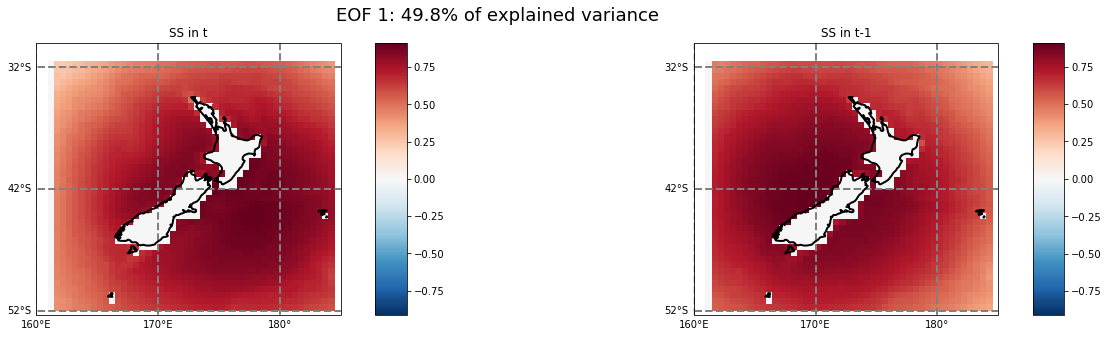

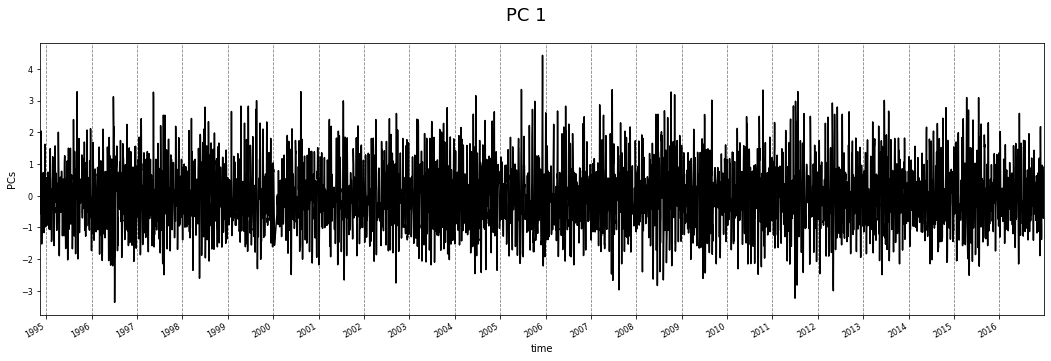

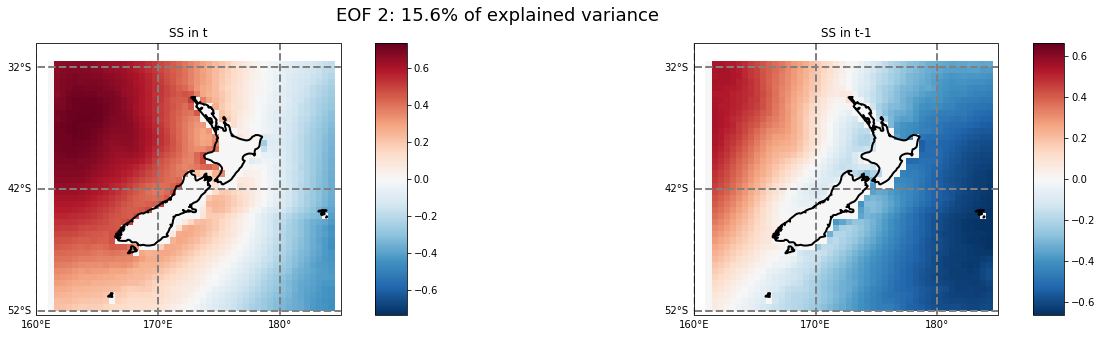

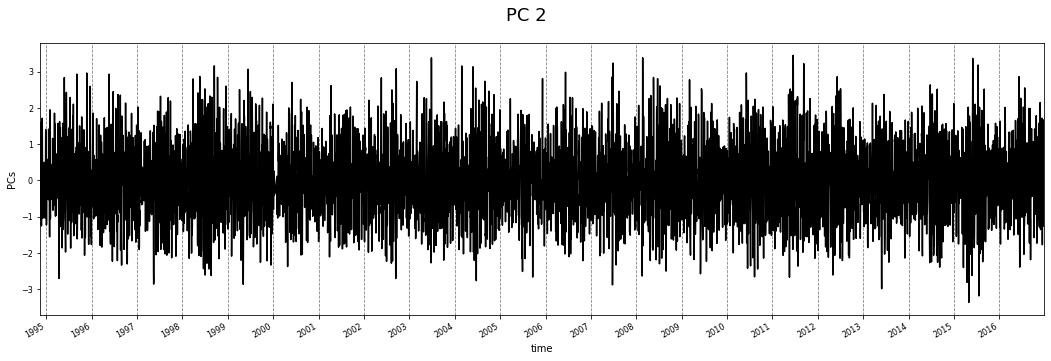

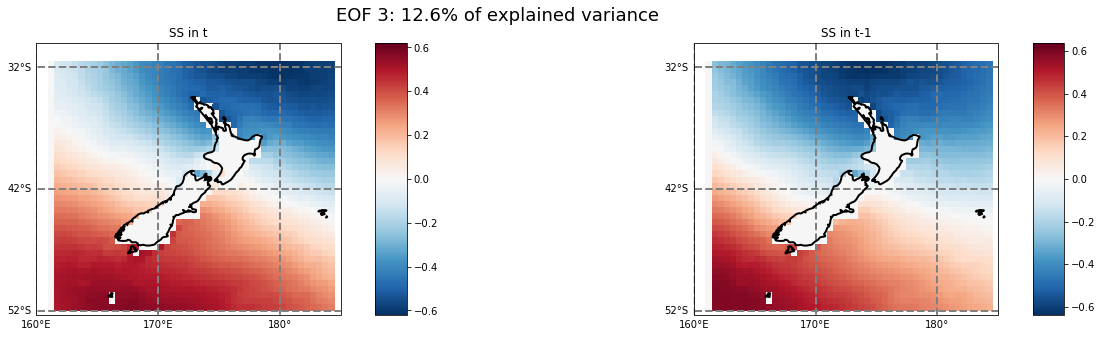

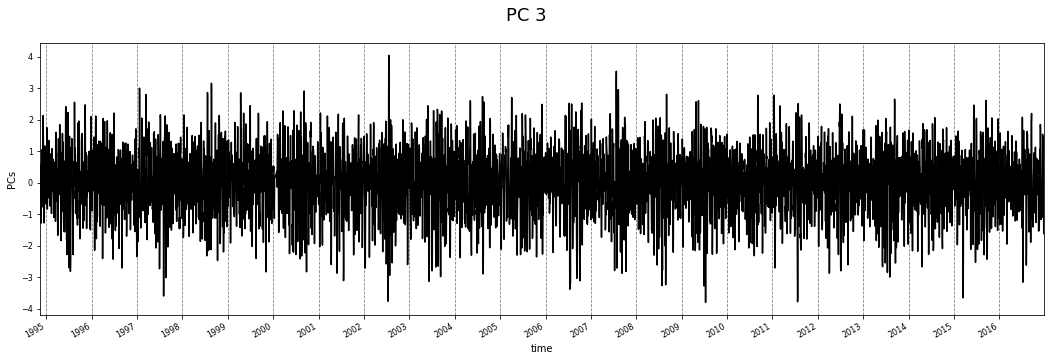

In [7]:
# calculate the pcs of the storm surge
interp_ss = True
if interp_ss:
    import numpy as np
    from sscode.config import default_region_reduced
    pcs_ss, ss_scaler = PCA_DynamicPred(
        load_moana_hindcast_ss(daily=True).interp(
            lon=np.arange(161,185,0.5),
            lat=np.arange(-52,-31,0.5)
        ).sortby('lat',ascending=False),
        pres_vars=('ss','lon','lat'),
        time_resample='1D', time_lapse=2,
        region=(True,default_region_reduced), 
        pca_plot=(True,False,3),
        pca_ttls=['SS in t', 'SS in t-1']
    )